In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import time

from dfply import *

from scipy.cluster.hierarchy import dendrogram, linkage

# First Ideas and Explorations
This is where we start to get serious. We have an idea of what data we have, and we saw that mean lap times do not distinguish between drivers. In this notebook, we hope that differences in lap times are more meaningful.

In [2]:
lap_times = pd.read_csv("f1db_csv/lap_times2018.csv")
df_drivers = pd.read_csv("f1db_csv/driver.csv")

In [3]:
def driver_name(driverId):
    driver = df_drivers.loc[ df_drivers["driverId"]==driverId, "surname"].values[0]
    
    return driver

We'll start with just two drivers in Australia: Hamilton and Vettel.

In [4]:
australia = (lap_times >> mask(X.raceId == 989))

# Vettel's database
vet = (lap_times >>
       mask(X.raceId == 989, X.driverId==20) >>
       arrange(X.lap))

# Hamilton's database
ham = (lap_times >>
       mask(X.raceId == 989, X.driverId==1) >>
       arrange(X.lap))

# Number of laps in the race
num_laps = max((lap_times >>mask(X.raceId == 989)).lap)

In [5]:
total_vet = 0
total_ham = 0

ham_diff = []
vet_diff = []

for i in range(num_laps):
    # Place after the i-th lap
    vet_pos = vet.iloc[i]["position"]
    ham_pos = ham.iloc[i]["position"]
    
    vet_lap = vet.iloc[i]["milliseconds"]
    ham_lap = ham.iloc[i]["milliseconds"]
    
    total_vet += vet_lap
    total_ham += ham_lap
    
    # Look who is ahead
    if(ham_pos < vet_pos):
        # If Ham is ahead, calculate Vet's difference
        ham_diff.append(0)
        vet_diff.append(total_vet - total_ham)
    else:
        # Do the opposite otherwise
        ham_diff.append(total_ham - total_vet)
        vet_diff.append(0)

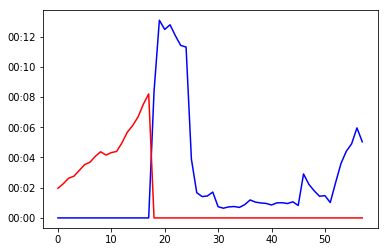

In [6]:
tt = range(num_laps)

fig, ax = plt.subplots();

plt.plot(tt, ham_diff, color="blue")
plt.plot(tt, vet_diff, color="red")

formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
ax.yaxis.set_major_formatter(formatter)

plt.show()

# Time differences
Here we calculate the gap to first place. We also have a function to plot it

In [7]:
def delta_to_first(race, df=lap_times):
    race_df  = (df >>
                mask(X.raceId == race) >>
                arrange(X.lap))

    # Number of laps
    num_laps = max(race_df.lap)

    # Drivers that finished the race
    drivers = (race_df >>
               mask(X.lap == num_laps) >>
               select(X.driverId))
    drivers = np.unique(drivers.driverId)

    # Differences
    diff = {}
    total_times = {}
    driver_times = {}

    for driver in drivers:
        diff[driver] = []
        total_times[driver] = 0
        driver_times[driver] = 0

    for i in range(1,num_laps+1):
        # lt stands for lap times
        lt = (race_df >> mask(X.lap==i))

        # Find first place
        first = lt.loc[ lt["position"].idxmin() ]["driverId"]

        # Get lap times
        for driver in drivers:
            driver_times[driver] = lt.loc[ lt["driverId"]==driver, "milliseconds"].values[0]
            total_times[driver] += driver_times[driver]

        # Calculate differences
        for driver in drivers:
            diff[driver].append(np.abs(total_times[first] - total_times[driver]))
        
    return(diff, drivers)

def plot_delta_to_first(race, df=lap_times):
    # Plot all differences in the same graph
    diff2, drivers = delta_to_first(989, df=df)

    formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
    fig, ax = plt.subplots();

    for driver in drivers:
        plt.plot(diff2[driver], label=driver_name(driver))

        ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))

        ax.yaxis.set_major_formatter(formatter)

Plotting the gaps in a single race for every driver individually:

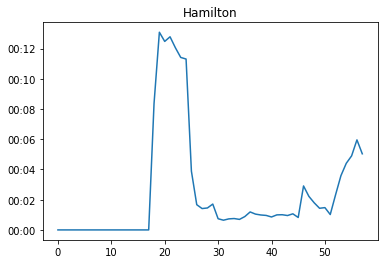

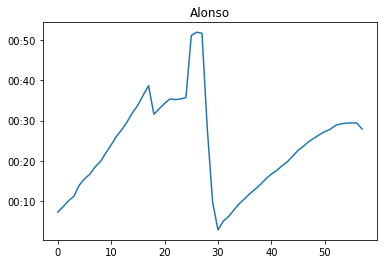

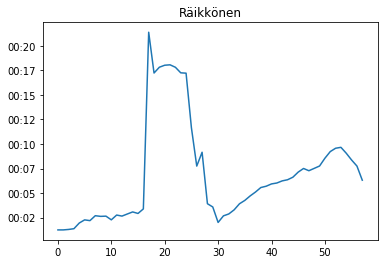

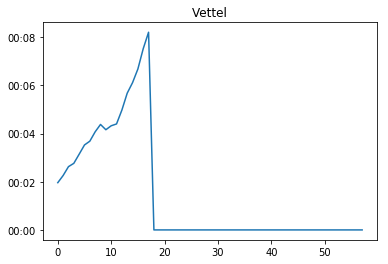

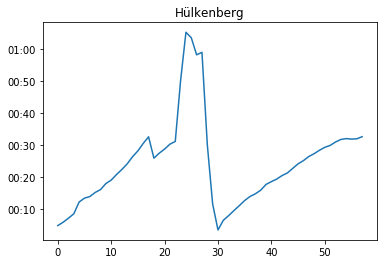

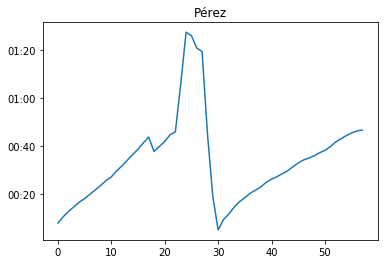

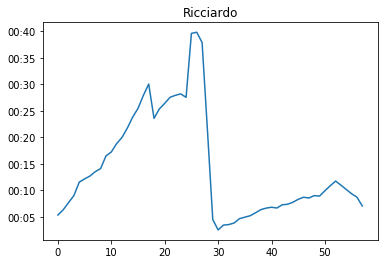

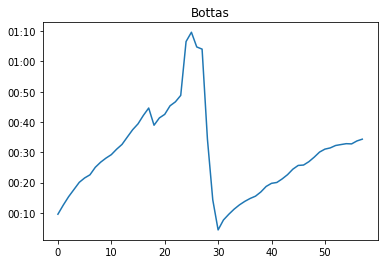

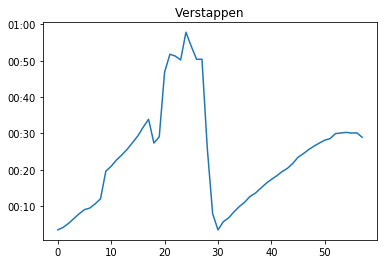

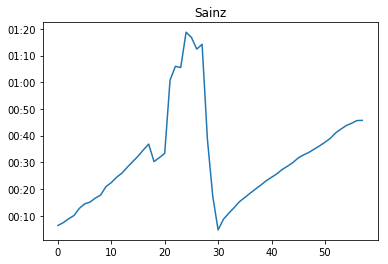

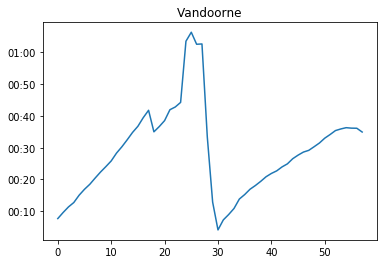

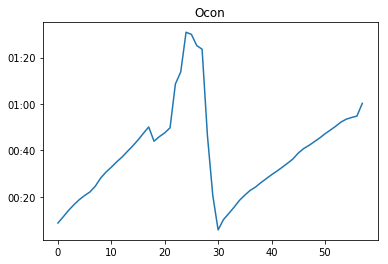

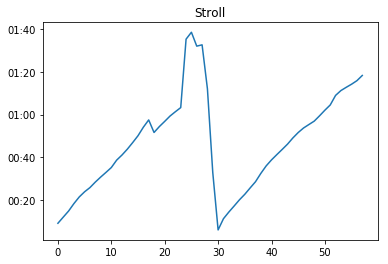

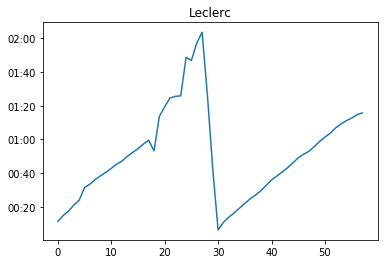

In [8]:
# Plot all differences
diff, drivers = delta_to_first(989)
tt = range(num_laps)
formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))

for driver in drivers:
    fig, ax = plt.subplots();

    plt.plot(tt, diff[driver])
    plt.title(driver_name(driver))
    
    ax.yaxis.set_major_formatter(formatter)

And now all together

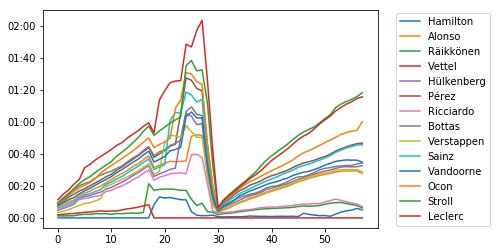

In [9]:
plot_delta_to_first(989)

season_dendrogram = plt.gcf()
plt.savefig("results/Australia lap deltas.png", bbox_inches='tight')

# Try to define a distance
Define a metric between two drivers as: $ \frac{1}{n} \sum_{i=1}^n (t_i - s_i)^2 $ where $t_i$ is the lap time of the first driver in lap $i$ (same for $s_i$) and $n$ is the number of laps in the race.

EDIT 1: Using an L2-type metric $ \frac{1}{n} \sqrt{\sum_{i=1}^n (t_i - s_i)^2}$ gives better results.

EDIT 2: How about using minutes instead of seconds?

EDIT 3: I don't see any difference in using minutes or seconds. We'll stick with seconds

In other words, our metric is the mean squared distance between lap times in a single race.

In [10]:
def lap_differences(driver1, driver2, raceId, df=lap_times):
    # Gives a list with the difference lap times of driver1 minus those of driver2
    race_times  = (df >>
                   mask(X.raceId == raceId, (X.driverId==driver1) | (X.driverId==driver2)) >>
                   arrange(X.lap))

    # Get times for each driver
    times1 = (race_times >>
              mask(X.driverId==driver1) >>
              select(X.milliseconds, X.lap))
    
    times2 = (race_times >>
              mask(X.driverId==driver2) >>
              select(X.milliseconds, X.lap))
    
    # Get the laps that they both did
    laps1 = max(times1.lap)
    laps2 = max(times2.lap)
    minlaps = min(laps1, laps2)

    # The difference
    diff = np.array((times1.milliseconds).add(-times2.milliseconds.values))
    
    # Turn it into seconds (not milliseconds) before returning
    return(diff/1000)

def delta_per_lap(driver1, driver2, raceId, df=lap_times):
    # Get the difference in each lap time
    diff = lap_differences(driver1, driver2, raceId, df=df)
    
    # To get the difference on track, do the cumulative sum
    delta = [0]
    for i in range(len(diff)):
        delta.append( delta[i]+diff[i] )
    
    return(np.array(delta))

def sum_of_squares(vector):
    return(np.sum(np.square(np.array(vector))))

def mse(vector):
    return(np.mean(np.square(np.array(vector))))

def l2(vector):
    vector = np.array(vector)
    return( np.sqrt(np.sum(np.square(vector)))/vector.size )

The above functions match the calculations we'd done before, except for a slight offset. There is a 0 in the first entry, but it doesn't change the analysis at all.

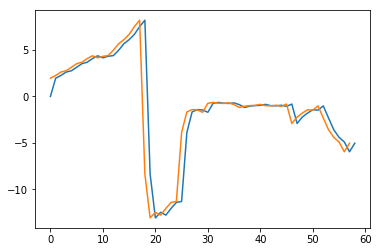

In [11]:
delta = delta_per_lap(1,20,989)

plt.plot(-np.array(delta))
plt.plot((-np.array(ham_diff) + np.array(vet_diff))/1000)

Now, let's try to do some clustering on a single race with the drivers that finished

In [12]:
def race_distances(raceId, df = lap_times, method=l2):
    # Get the drivers that finished in this race
    race_times  = (df >>
                   mask(X.raceId == raceId) >>
                   arrange(X.lap))

    # Number of laps
    num_laps = max(race_times.lap)

    # Drivers that finished the race (sort them by position)
    drivers = (race_times >>
               mask(X.lap == num_laps) >>
               arrange(X.position))

    #drivers = np.unique(drivers.driverId.values)
    
    drivers = drivers.driverId.values
    _, idx = np.unique(drivers, return_index=True)
    drivers = drivers[np.sort(idx)]

    # Get all distances
    distances = []
    for i in range(len(drivers)):
        row = []
        for j in range(len(drivers)):
            driveri = drivers[i]
            driverj = drivers[j]

            row.append( method(delta_per_lap(driveri, driverj, raceId, df=df)) )

        distances.append(row)

    distances = np.array(distances)
    return(distances, drivers)

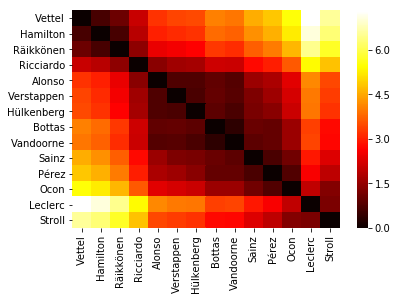

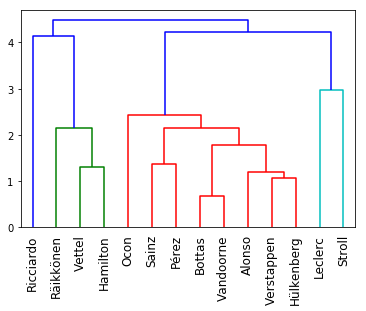

In [13]:
distances, drivers = race_distances(989, method=l2)
names = [driver_name(id) for id in drivers]

sns.heatmap(distances, cmap="hot",
            xticklabels=names, yticklabels=names)

plt.figure()
linked = linkage(distances);
diag = dendrogram(linked, labels=names, leaf_rotation=90)

# Filling missing data
## Big gaps
Ok, this is working very well! The only problem is that we can only evaluate the drivers that finished the race and have a gap smaller than 1 lap. We need to find a way to incorporate all drivers into the ranking. For those that were n laps behind, we can simply copy their last lap time.

NOTE: This is not standard. We do this just to fill available space.

In [14]:
def fill_laps_behind(data, race, driver):
    # Get the total laps in the race
    num_laps = max((data >> mask(X.raceId == race)).lap)
    
    # Get the laps our driver did
    driver_laps = max((data >> mask(X.raceId == race, X.driverId==driver)).lap)
    
    # Now we get the last available lap
    last_lap = (data >> mask(X.raceId==race, X.driverId==driver, X.lap==driver_laps))
    
    # And we copy that lap until we fill all remaining laps
    new_data = data.copy()
    for i in range(driver_laps+1, num_laps+1):
        filler_lap = last_lap.copy()
        
        # Update the lap number
        filler_lap.lap = i
        
        # Add to the race data frame
        new_data = pd.concat([new_data, filler_lap])

    # Sort the array into a nice shape so as to not mess up with future analises.
    new_data = (new_data >>
                arrange(X.raceId, X.driverId, X.lap))

    return(new_data)

Ok, we filled missing laps. Let's calculate distances again. We should expect the drivers with filled laps to be further away from the leaders than the previous last place drivers.

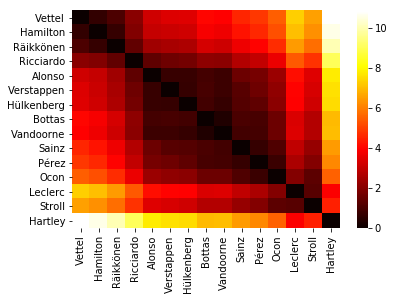

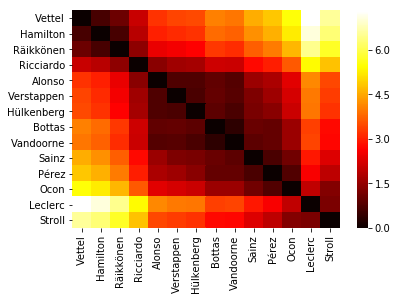

In [15]:
# Fill laps
australia_filled = fill_laps_behind(australia, 989, 843)

# Calculate distances
distances_f, drivers_f = race_distances(989, df=australia_filled)
names_f = [driver_name(id) for id in drivers_f]

# Plot them
sns.heatmap(distances_f, cmap="hot",
            xticklabels=names_f, yticklabels=names_f)

# Compare this with the old ranking
distances, drivers = race_distances(989)
names = [driver_name(id) for id in drivers]

plt.figure()
sns.heatmap(distances, cmap="hot",
            xticklabels=names, yticklabels=names)

The driver that finished with a one lap gap in Australia was Brendon Hartley. Indeed, our heatmap shows that he is considerably behind the rest of the pack.

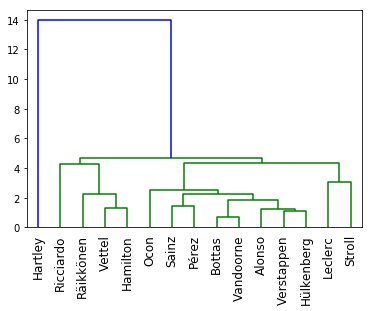

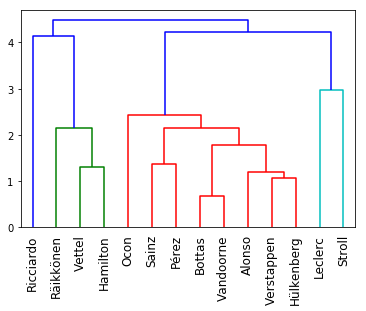

In [16]:
# And compare the dendrograms
plt.figure()
linked_f = linkage(distances_f);
diag = dendrogram(linked_f, labels=names_f, leaf_rotation=90)

plt.figure()
linked = linkage(distances);
diag = dendrogram(linked, labels=names, leaf_rotation=90)

The dendrograms tell a similar story. Note that Hartley had a big gap throughout the whole race, so his distance is big enough as to deserve a single leaf in the dendrogram.

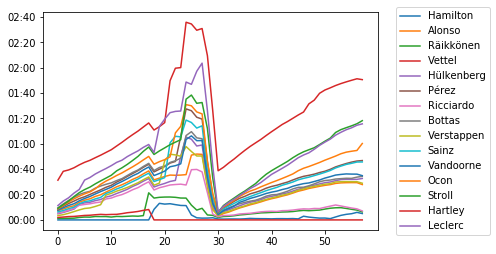

In [17]:
plot_delta_to_first(989, df=australia_filled)

## DNF's
DNF's are more problematic. We want to penalize DNF's but not too heavily as to skew the overall model. Some ideas come to mind to fill the missing laps:
- Assign the slowest lap time available in each lap.
- Assign the lap time of the driver that finished in the place the current driver retired from. (Eg. driver 10 crashed, so we fill in the lap times of the driver that finished the race in 10th place).
- Assign the average of all other lap times.

We will define the three methods above and evaluate the performance of the final model.

In [18]:
def ms_to_minutes(milliseconds):
    minutes = int((milliseconds // 1000)//60)
    seconds = int((milliseconds // 1000) % 60)
    ms = round(milliseconds % 1000)
    
    # Extra format. We don't want 2 seconds, but 02 instead.
    if(seconds < 10):
        seconds = "0" + str(seconds)
    # Likewise, we don't want 1.1 seconds but 1.001.
    if(ms < 10):
        ms = "00" + str(ms)
    elif(ms < 100):
        ms = "0" + str(ms)
    else:
        ms = str(ms)
    
    return("%d:%s.%s" % (minutes, seconds, ms))

ms_to_minutes(97001.052632)

'1:37.001'

In [19]:
def slowest_time(data, race, driver, lap_index):
    # Picks the slowest time in the lap (ie. the biggest time)
    lap_df = (data >>
              mask(X.raceId==race, X.lap==lap_index))
    
    return(max(lap_df.milliseconds.values))

def same_position(data, race, driver, lap_index):
    # Finds the position of our driver in his last lap
    driver_df = (data >> mask(X.raceId==race, X.driverId==driver))
    
    # If the driver didn't finish one lap, we're in trouble
    if(driver_df.size == 0):
        return(slowest_time(data, race, driver, lap_index))

    # If he did, we get the last lap and his position in his last lap.
    last_lap = max(driver_df.lap.values)
    position = (driver_df >> mask(X.lap==last_lap)).position.values[0]

    # If our driver DNF'd from last place, we default to the slowest time.
    # We get the positions in this lap, but we remove 21's (ie. drivers that already retired)
    places = (data >> mask(X.raceId==race, X.lap==lap_index, X.position != 21)).position.values
    last_place = max(places)
    
    
    last_place = max((data >> mask(X.raceId==race, X.lap==lap_index)).position.values)
    if(position > last_place):
        return(slowest_time(data, race, driver, lap_index))

    # And we pick the lap time of the driver in our driver's last known position
    position_df = (data >> mask(X.raceId==race, X.position==position, X.lap==lap_index))
    new_time = position_df.milliseconds.values[0]
    
    return(new_time)

def average_time(data, race, driver, lap_index):
    # Now we don't worry about which driver retired. We just calculate the average of the other times.
    time_df = (data >> mask(X.raceId==race, X.lap==lap_index)).milliseconds.values
    
    return(int(round(np.mean(time_df))))

In [20]:
def fill_laps(data, race, driver, method=slowest_time):
    # Get the total laps in the race
    num_laps = max((data >> mask(X.raceId == race)).lap)
    
    # Get the laps our driver did
    driver_df = (data >> mask(X.raceId == race, X.driverId==driver))
    
    # We register if the driver retired without completing a lap.
    if(driver_df.size==0):
        # No laps completed
        driver_laps=0
        
        # Get the data from the first lap
        row = (data >> mask(X.raceId==race, X.lap==1))
        test_driver = row.driverId.values[0]   # This way we choose one row from the data frame
        row = (row >> mask(X.driverId==test_driver))
        
        # Create a copy for our driver
        last_driver_lap = row.copy()
        
        # Populate with our driver's information
        last_driver_lap.driverId = driver
        last_driver_lap.position = 21

    # If not, we proceed as normal.
    else:
        driver_laps = max(driver_df.lap.values)
        last_driver_lap = (driver_df >> mask(X.lap == driver_laps))
    
    # And we copy that lap until we fill all remaining laps
    new_data = data.copy()
    for lap_index in range(driver_laps+1, num_laps+1):
        filler_time = method(data, race, driver, lap_index)
        
        # Update the lap number, time and position
        filler_lap = last_driver_lap.copy()
        
        filler_lap.lap = lap_index
        filler_lap.position = 21
        filler_lap.milliseconds = filler_time
        filler_lap.time = ms_to_minutes(filler_time)
        
        # Add to the race data frame
        new_data = pd.concat([new_data, filler_lap])

    # Sort the array into a nice shape so as to not mess up with future analises.
    new_data = (new_data >>
                arrange(X.raceId, X.driverId, X.lap))

    return(new_data)

Testing that everything works as expected:

In [21]:
# This should be Brendon Hartley's 2:05.584 first lap in Australia 2018 (125584 milliseconds).
print("Expected:   125584")
print("Calculated:", slowest_time(lap_times, 989, "anything", 1))

# Romain Grosjean's wheel came off when he was 7th in lap 24.
# The driver that took 7th place in lap 25 was Stoffel Vandoorne and he did a 1:48.016 (108016 ms).
print("Expected:   108016")
print("Calculated:", same_position(lap_times, 989, 154, 25))

# We have to test the default case when the driver DNF'd without completing a lap,
# such as Fernando Alsonso on lap 1 in Spa.
# The slowest time was Raikonnen's 3:27.671 (207671 ms).
print("Expected:   207671")
print("Calculated:", same_position(lap_times, 1001, 4, 1))

# Or when the driver retires from last place. Daniel Ricciardo was an example in Spa.
# He retired after being 16th in lap 28. The 15th place in the next lap was Stfofel Vandoorne with a 2:04.389 lap time.
print("Expected:   124389")
print("Calculated:", same_position(lap_times, 1001, 817, 29))

# Taking Spa's lap 29 as an example once more, we get:
print("Expected:  ", 
    np.mean([106972,107403,107273,112864,108103,108883,109004,108225,109169,109011,111701,109817,109822,109794,124389]))
print("Calculated:", average_time(lap_times, 1001, 817, 29))

Expected:   125584
Calculated: 125584
Expected:   108016
Calculated: 108016
Expected:   207671
Calculated: 207671
Expected:   124389
Calculated: 124389
Expected:   110162.0
Calculated: 110162


And now we test the fill_laps method, to check that it correctly populates the new lap times.

For this, we'll use Brendon Hartley's race on China. He completed 51 of the 56 laps. We will check by hand that all the results fit what we expect.

In [22]:
(fill_laps(lap_times, 991, 843, method=average_time) >>
 mask(X.driverId==843, X.raceId==991))

,raceId,driverId,lap,position,time,milliseconds
2943,991,843,1,17,1:51.539,111539
2895,991,843,2,18,1:43.976,103976
2874,991,843,3,18,1:42.609,102609
2888,991,843,4,19,1:43.317,103317
2858,991,843,5,19,1:42.216,102216
2862,991,843,6,19,1:42.276,102276
2853,991,843,7,19,1:42.186,102186
2825,991,843,8,19,1:41.762,101762
2813,991,843,9,19,1:41.626,101626
2922,991,843,10,20,1:46.763,106763


We check what happens when we populate Alonso's race from Spa. He did not complete one lap, so we'll check if our methods identify edge cases correctly.

In [23]:
(fill_laps(lap_times, 1001, 4, method=slowest_time) >>
 mask(X.driverId==4, X.raceId==1001))

,raceId,driverId,lap,position,time,milliseconds
13757,1001,4,1,21,3:27.671,207671
13757,1001,4,2,21,8:44.604,524604
13757,1001,4,3,21,2:51.296,171296
13757,1001,4,4,21,3:01.499,181499
13757,1001,4,5,21,1:56.000,116000
13757,1001,4,6,21,1:55.067,115067
13757,1001,4,7,21,2:02.327,122327
13757,1001,4,8,21,2:32.947,152947
13757,1001,4,9,21,1:53.535,113535
13757,1001,4,10,21,1:53.191,113191


# Aggregating metrics
The next step is to define a metric for the whole season. The idea is to add the metrics from each race. We will weight each race by its qualyfing time. This should balance the track length and, perhaps, also the difficulty.


# Functions
We defined several functions in this notebook. We will be using them a lot, so we will copy them to a file that doesn't do the plots. It will also have more detailed explanations of the functions.